In [7]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import (cross_val_score, KFold)
from sklearn.metrics import mean_squared_error


In [3]:
dataset = pd.read_csv('./datasets/felicidad.csv')

#X = dataset.drop(['country', 'score'], axis=1)
#y = dataset['score']

X = dataset.drop(["country","score"],axis=1)
y = dataset["score"]

## validacion cruzada basica 

In [4]:
# seleccion de modelo
model = DecisionTreeRegressor()

# Implementacion básica de Cross validation para calcular un score
score = cross_val_score(model, X, y,
                        cv=3, # se define el numero de split 
                        scoring='neg_mean_squared_error') # la metrica de validacion 

# Cada elemento del array score es el error medio cuadratico
print("Los tres MSE fueron: ", score) #estos son errores medios cuadraticos de cada split
print('='*32)
print("El MSE promedio fue: ", np.abs(np.mean(score))) # se recomienda presentar esta metrica asi 

Los tres MSE fueron:  [-0.84377295 -0.15841133 -0.68847991]
El MSE promedio fue:  0.5635547298996498


# validacion cruzada avanzada
Se hizo una implementacion mas sofisticada de CV que se llama K Fold Cross validation para calcular separar los datos en sus respectivos dataset y poder entrenar a nuestro modelo manualmente.

es lo mismo de atras solo que en esta version podemos manipular mas parametros

In [13]:
# creamos una funcion para crear X y y
def X_y(ds):
    X = ds.drop(["country","score"],axis=1)
    y = ds["score"]
    return X, y

kf = KFold(n_splits=3, shuffle=True, random_state=42)

mse_values = []
for train, test in kf.split(X):# train y test contienen los indices de las particiones
    #hacemos el split manuelmente (simulando train_test_split, pero con las particiones de CV)
    X_train, y_train = X_y(dataset.loc[train,:]) 
    X_test, y_test = X_y(dataset.loc[test,:])

    model = DecisionTreeRegressor(random_state=42).fit(X_train,y_train)
    predict = model.predict(X_test)
    mse_values.append(mean_squared_error(y_test,predict))

print("Los tres MSE fueron: ",mse_values)
print("El MSE promedio fue: ", np.mean(mse_values))

Los tres MSE fueron:  [0.008245999424145068, 0.012547118703889398, 0.006206374979006815]
El MSE promedio fue:  0.008999831035680425


# optimizacion parametrica

In [19]:
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

## randomized 

In [16]:
dataset = pd.read_csv("./datasets/felicidad.csv")

# La razón de eliminar el rank y el score, 
# es porque se quiere que los features no tengan ninguna correlación entre ellos.
# Lo ideal es que exista correlación solo entre las features y la variable objetivo.
X = dataset.drop(['country', 'rank', 'score'], axis=1)
y = dataset[['score']]

In [17]:
reg = RandomForestRegressor()

parameters = {
    'n_estimators': range(4, 16), # cuantos arboles compondran mi arbol
    'criterion': ['mse', 'mae'], # funcion de coste usada
    'max_depth': range(2, 11)   # profundidad del arbol 
}

# son 10 iteracion del optimizador. Toma 10 combinaciones al azar del diccionario
# cv = 3, parte en 3 parte el set de datos que le pasemos, para hacer Cross validation
rand_est = RandomizedSearchCV(reg, parameters, 
                                n_iter=10, 
                                cv=3, 
                                scoring='neg_mean_absolute_error',
                                ).fit(X, y)

In [18]:
print("Mejores estimadores")
print(rand_est.best_estimator_)
print('='*64)

print("Mejores parametros")
print(rand_est.best_params_)
print('='*64)

y_hat = rand_est.predict(X.loc[[0]]) 
print(f'Predict: {y_hat[0]}')
print(f'Real:    {y.loc[0]}')


Mejores estimadores
RandomForestRegressor(criterion='mae', max_depth=9, n_estimators=4)
Mejores parametros
{'n_estimators': 4, 'max_depth': 9, 'criterion': 'mae'}
Predict: 7.52625012375
Real:    score    7.537
Name: 0, dtype: float64


## plot grid results

In [82]:
# juntamos los datos en un dataframe
def data_results(grid):
    results = grid.cv_results_
    masks_names= list(grid.best_params_.keys())
    params = results["params"]
    p_v = {}
    for p in masks_names:
        x_li =[]
        for it in params:
            x_li.append(it[p])
        p_v[p] = x_li
    data = pd.DataFrame(p_v)
    data["means_test"] = np.abs(results['mean_test_score'])
    data["stds_test"] = results['std_test_score']
    return data
data_results(rand_est).head(3)

,n_estimators,max_depth,criterion,means_test,stds_test
0,7,3,mae,0.683356,0.209391
1,9,6,mse,0.635646,0.233242
2,4,9,mae,0.618775,0.209737


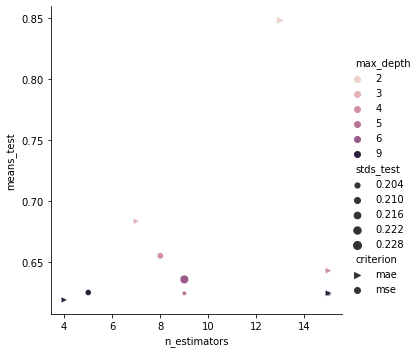

In [81]:
import seaborn as sns
markers = {"mae": ">", "mse":"o"}
sns.relplot(data = data_results(rand_est), x="n_estimators", y = "means_test", #hasta aqui tendriamos una scatter plot normal pero podemos mas...
                hue="max_depth",
                style="criterion",markers= markers, alpha=1,
                size="stds_test"
            )
plt.show()

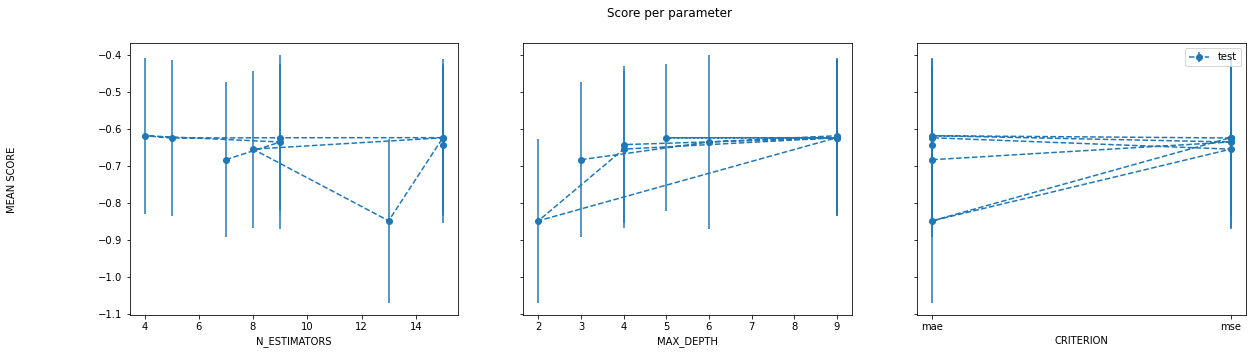

In [75]:
def plot_search_results(grid):
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']    

    ## Ploting results
    fig, ax = plt.subplots(1,len(grid.best_params_),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    
    masks_names= list(grid.best_params_.keys())
    params = results["params"]
    for i, p in enumerate(masks_names):
        x_li =[]

        for it in params:
            x_li.append(it[p])
        x = np.array(x_li)
        y_1 = np.array(means_test)
        e_1 = np.array(stds_test)
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()
plot_search_results(rand_est)